# 14. CNN with CIFAR10

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## 14.1 Prepare Data

In [4]:
train_data = dsets.CIFAR10(root='./data', 
                           train=True,
                           download=True, 
                           transform=transforms.ToTensor())

test_data  = dsets.CIFAR10(root='./data', 
                           train=False,
                           download=True, 
                           transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 128

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data, 
                         batch_size=5,
                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

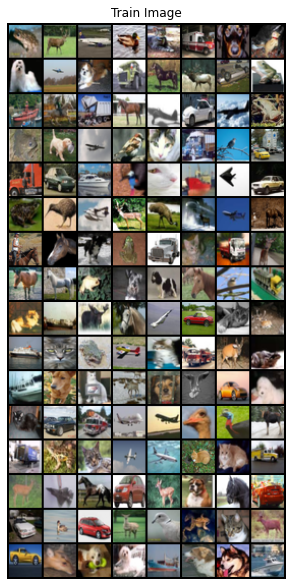

In [7]:
train_iter = iter(train_loader)
images, labels = train_iter.next()

imshow(images, "Train Image")

In [8]:
images.shape  #128개(1배치) 데이터가 한번에 인풋 (32x32 image, rgb)

torch.Size([128, 3, 32, 32])

## 14.2 Define Model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5), #(128,32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2,2), #(128,32,14,14)
            nn.Conv2d(32, 64, 5), #(128,64,10,10)
            nn.ReLU(),
            nn.MaxPool2d(2,2) #(128,64,5,5)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64*5*5, 100), #100개로 줄였다가
            nn.ReLU(),
            nn.Linear(100, 10)     #최종 10개 클래스로 분류         
        )
        
    def forward(self, x): #전진학습
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out
    
model = CNN()

In [11]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 14.3 Train Model

In [12]:
num_epochs = 10

In [14]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        #X = batch_images.cuda()
        #Y = batch_labels.cuda()
        X = batch_images
        Y = batch_labels

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [200/390], Loss: 2.2980
Epoch [2/10], lter [200/390], Loss: 2.2713
Epoch [3/10], lter [200/390], Loss: 2.0065
Epoch [4/10], lter [200/390], Loss: 1.9235
Epoch [5/10], lter [200/390], Loss: 1.6115
Epoch [6/10], lter [200/390], Loss: 1.7658
Epoch [7/10], lter [200/390], Loss: 1.6327
Epoch [8/10], lter [200/390], Loss: 1.4772
Epoch [9/10], lter [200/390], Loss: 1.6151
Epoch [10/10], lter [200/390], Loss: 1.6307


## 14.4 Test Model

In [15]:
correct = 0
total = 0

for images, labels in test_loader:
    
    #images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1) #dim=1 기준으로 최대값 반환->(값, 인덱스) tuple 형태
    
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 45.550000 %


Predicted:    cat  ship  ship  ship  frog


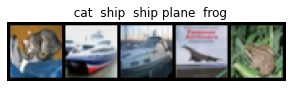

In [17]:
images, labels = iter(test_loader).next()
outputs = model(images)

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5))) #예측 결과

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(images, title) #원래 데이터